# Activation plots in Keras
### Dr. Tirthajyoti Sarkar, Fremont, CA 94536 ([LinkedIn](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), [Github](https://tirthajyoti.github.io))

For more tutorial-style notebooks on deep learning, **[here is my Github repo](https://github.com/tirthajyoti/Deep-learning-with-Python)**.

For more tutorial-style notebooks on general machine learning, **[here is my Github repo](https://github.com/tirthajyoti/Machine-Learning-with-Python)**.

---

It is fascinating to look at the activation maps of convolutional neural networks to try to see and understand the various levels of complex features maps the network is 'seeing' and processing to classify the image.

In this notebook, we show how to generate such activation maps using [`Keract` package](https://github.com/philipperemy/keract). It is a high-level accessory library to Keras library to show useful heatmaps and activation maps on various layers of a neural network.

We also use couple of utility functions from my `utils.DL_utils` module - `train_CNN_keras` and `preprocess_image` to make a random RGB image compatible for generating the activation maps.

So, the whole process is done in only a few lines of code!

![keract](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/keract-header.PNG)

### Import utility functions from `utils.DL_utils` module

You can **[download this utility module from here](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/Notebooks/utils/DL_utils.py)**.

In [2]:
from utils.DL_utils import train_CNN_keras,preprocess_image

In [15]:
import pandas as pd
import os
train_dataframe = pd.read_csv(os.path.join("/Users/wungjaelee/Everything/RESEARCH/gazing_estimation_florian/activation_map/data/random_sinusoid_period_8", "eye_rotations.csv"))

print(train_dataframe.head(5))


                                          image_name    azimuth  elevation
0  sinusoid-0_-7.150982152169262_-7.1509821521692...  -7.150982  -7.150982
1  sinusoid-1_-0.466664551802269_-7.1509821521692...  -0.466665  -7.150982
2  sinusoid-2_14.81655691553061_-7.15098215216926...  14.816557  -7.150982
3  sinusoid-3_4.282040529968586_-7.15098215216926...   4.282041  -7.150982
4  sinusoid-4_11.30282519368279_-7.15098215216926...  11.302825  -7.150982


In [23]:
def train_CNN_regression(
    train_dataframe,
    train_directory,
    x_col,
    y_col,
    target_size=(256, 256),
    batch_size=128,
    num_output=2,
    num_epochs=20,
    verbose=0,
):
    """
    Trains a conv net for a given dataset contained within a training directory.
    Users can just supply the path of the training directory and get back a fully trained, 5-layer, convolutional network.
    
    Arguments:
            train_directory: The directory where the training images are stored in separate folders.
                            These folders should be named as per the classes.
            target_size: Target size for the training images. A tuple e.g. (200,200)
            classes: A Python list with the classes 
            batch_size: Batch size for training
            num_epochs: Number of epochs for training
            num_classes: Number of output classes to consider
            verbose: Verbosity level of the training, passed on to the `fit_generator` method
    Returns:
            A trained conv net model
    
    """
    from keras.layers import Conv2D, MaxPooling2D
    from keras.layers import Dense, Dropout, Flatten
    from keras.models import Sequential
    from keras.preprocessing.image import ImageDataGenerator
    
    # ImageDataGenerator object instance with scaling
    train_datagen = ImageDataGenerator(rescale=1 / 255)
    
    # Flow training images in batches using the generator
    train_generator = train_datagen.flow_from_dataframe(
        train_dataframe,  # This is the source dataframe for training images
        train_directory,  # This is the source directory for training images
        target_size=target_size,  # All images will be resized to 200 x 200
        x_col=x_col,  # column in dataframe that contains the filenames
        y_col=y_col,  # string or list of columns in dataframe that has the target data
        batch_size=batch_size,
        class_mode="multi_output",
        validate_filenames=True
    )

    input_shape = tuple(list(target_size) + [3])

    # Model architecture
    model = Sequential(
        [
            # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
            # The first convolution
            Conv2D(16, (3, 3), activation="relu", input_shape=input_shape),
            MaxPooling2D(2, 2),
            # The second convolution
            Conv2D(32, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            # The third convolution
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            # The fourth convolution
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            # The fifth convolution
            Conv2D(64, (3, 3), activation="relu"),
            MaxPooling2D(2, 2),
            # Flatten the results to feed into a dense layer
            Flatten(),
            # 512 neuron in the fully-connected layer
            Dense(512, activation="relu"),
            # Output neurons for `num_classes` classes with the softmax activation
            Dense(num_output),
        ]
    )

    # Optimizer and compilation
    model.compile(
        loss="mse", optimizer="Adam", metrics=["mse", "mae"]
    )

    # Total sample count
    total_sample = train_generator.n

    # Training
    model.fit_generator(
        train_generator,
        steps_per_epoch=int(total_sample / batch_size),
        epochs=num_epochs,
        verbose=verbose,
    )

    return model

In [26]:
import pandas as pd
import os
train_directory = "/Users/wungjaelee/Everything/RESEARCH/gazing_estimation_florian/activation_map/data/random_sinusoid_period_8"
train_dataframe = pd.read_csv(os.path.join(train_directory, "eye_rotations.csv"))
x_col = "image_name"
y_col = ["azimuth", "elevation"]
target_size = (256,256)
batch_size = 32
num_output = 2
num_epochs = 10

In [27]:
model = train_CNN_regression(train_dataframe=train_dataframe,
                             train_directory=train_directory,
                            x_col=x_col,
                            y_col=y_col,
                            num_output=num_output,
                            target_size=target_size,
                            batch_size=batch_size,
                            num_epochs=num_epochs,
                            verbose=1)

Found 1024 non-validated image filenames.
Epoch 1/10


ValueError: Error when checking model target: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[ 10.92784328],
       [ -4.72065721],
       [  5.63630996],
       [ -0.46666455],
       [  7.87030062],
       [  0.77258706],
       [  0.77258706],
       [ 11.30282519],
       [  0.514...

### Set parameters and training directory

For training, we are using the famous **Caltech-101 dataset** from http://www.vision.caltech.edu/Image_Datasets/Caltech101/. This dataset was somewhat a **precursor to the [ImageNet database](http://image-net.org)**, which is the current gold standard for image classification data repository.

![caltech-101](https://raw.githubusercontent.com/tirthajyoti/Deep-learning-with-Python/master/images/Caltech-101-header.PNG)


It is an image datasets of diverse types of objects belonging to 101 categories. There are about 40 to 800 images per category. Most categories have about 50 images.  The size of each image is roughly 300 x 200 pixels.

However, we are training only with 5 categories of images - _crab, cup, brain, camera_, and _chair_.

In [2]:
train_directory = "../Data/101_ObjectCategories/"
target_size=(512,512)
batch_size=4
classes = ['crab','cup','brain','camera','chair']
num_classes = len(classes)
num_epochs=10

### Train the model

In [3]:
model = train_CNN_keras(train_directory=train_directory,
                  num_epochs=num_epochs,
                  target_size=target_size,
                  classes = classes, 
                  batch_size=batch_size,
                  num_classes=num_classes,
                  verbose=1)

Using TensorFlow backend.


Found 340 images belonging to 5 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
85/85 [==============================] - 7s 79ms/step - loss: 1.6211 - acc: 0.2853
Epoch 2/10
85/85 [==============================] - 3s 35ms/step - loss: 1.4841 - acc: 0.3500
Epoch 3/10
85/85 [==============================] - 3s 35ms/step - loss: 1.1439 - acc: 0.5912
Epoch 4/10
85/85 [==============================] - 3s 35ms/step - loss: 0.7016 - acc: 0.7647
Epoch 5/10
85/85 [==============================] - 3s 35ms/step - loss: 0.3471 - acc: 0.8824
Epoch 6/10
85/85 [==============================] - 3s 35ms/step - loss: 0.2442 - acc: 0.9324
Epoch 7/10
85/85 [==============================] - 3s 35ms/step - loss: 0.2601 - acc: 0.9412
Epoch 8/10
85/85 [==============================] - 3s 35ms/step - loss: 0.2726 - acc: 0.9647
Epoch 9/10
85/85 [==============================] - 3s 35ms/step - loss: 0.2672 - acc: 

### A random image of a human brain downloaded from the internet

In [4]:
img_path = '../images/brain-1.jpg'

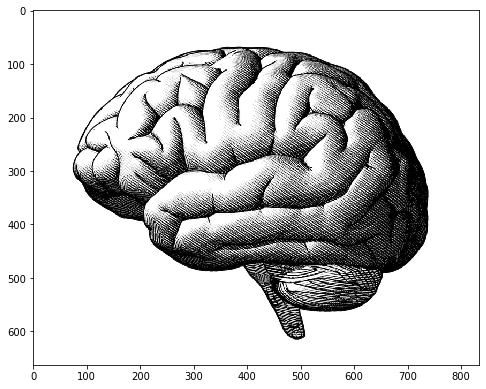

In [12]:
import matplotlib.pyplot as plt
import PIL
plt.figure(figsize=(8,7))
plt.imshow(PIL.Image.open(img_path))
plt.show()

### Just pass on the image path, model, and target size, to the `preprocess_image` function

In [13]:
x = preprocess_image(img_path=img_path,model=model,resize=target_size)

### We can check the model prediction (probabilities)

In [14]:
model.predict(x)

array([[9.8682110e-14, 1.9951642e-13, 1.0000000e+00, 1.3921631e-14,
        4.5632106e-11]], dtype=float32)

So, the 3rd class is being predicted by the trained model with close to 1 probability. That must be the brain class.

### Generate the activation maps

It is as easy as,
```
from keract import get_activations
activations = get_activations(model, x, layer_name)
```

- `model` is a keras.models.Model object.
- `x` is a numpy array to feed to the model as input. In the case of multi-input, x is of type List. We use the Keras convention (as used in predict, fit...).
- `layer_name` (optional) - the layer to get activations for if you only want the activations for one layer

In [15]:
from keract import get_activations
activations = get_activations(model, x)

### Display the activation maps
The code is,
```
from keract import display_activations
display_activations(activations, cmap="gray", save=False)
```
- `activations` a dictionary mapping layers to their activations (the output of get_activations)
- `cmap` (optional) a string of a valid matplotlib colourmap
- `save` (optional) a bool, if True the images of the activations are saved rather than being shown


conv2d_1/Relu:0 (1, 510, 510, 16) 


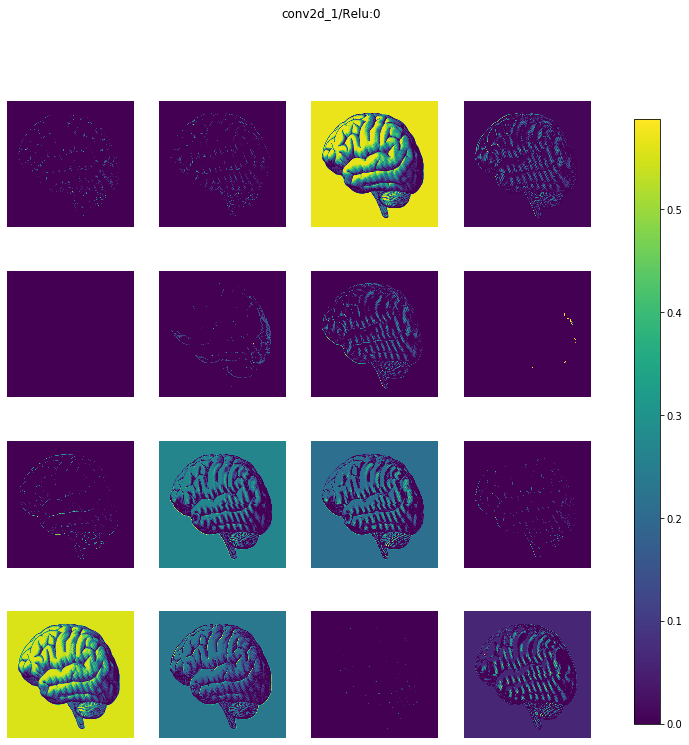

max_pooling2d_1/MaxPool:0 (1, 255, 255, 16) 


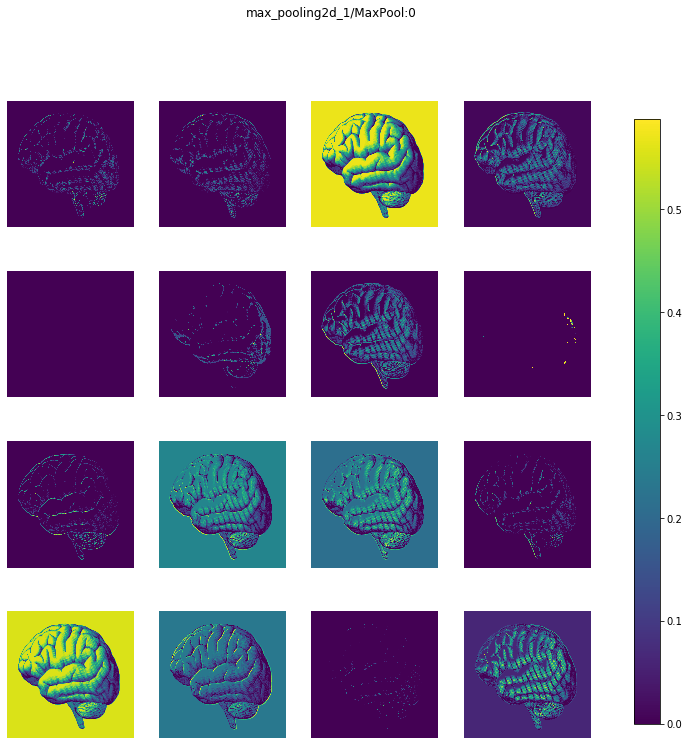

conv2d_2/Relu:0 (1, 253, 253, 32) 


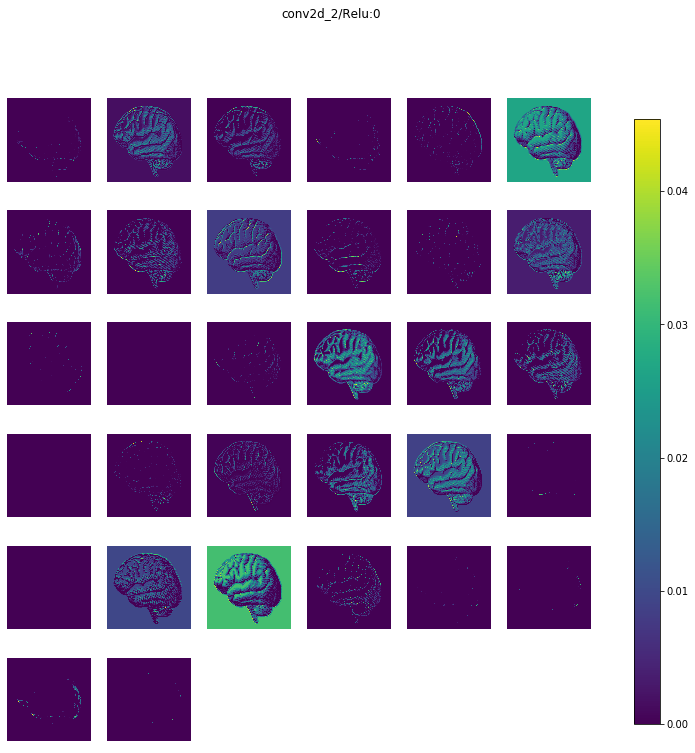

max_pooling2d_2/MaxPool:0 (1, 126, 126, 32) 


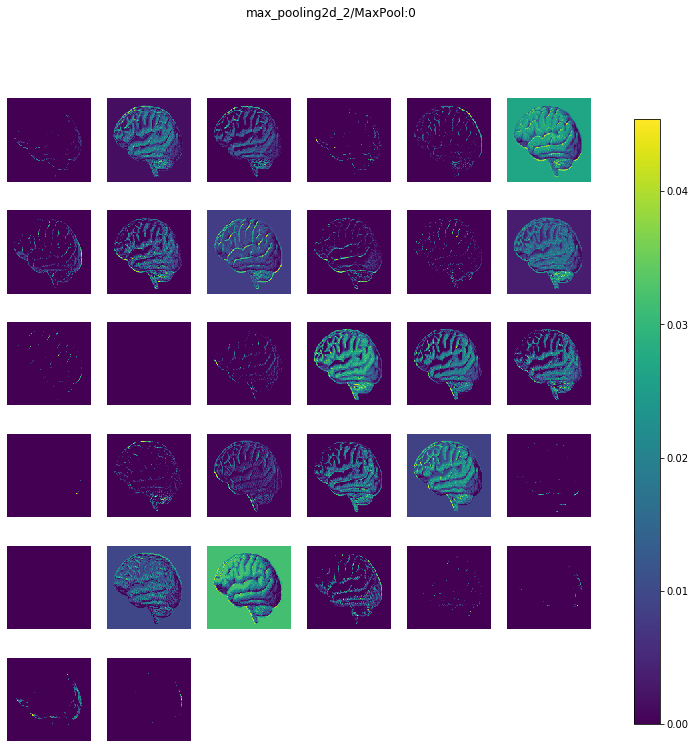

conv2d_3/Relu:0 (1, 124, 124, 64) 


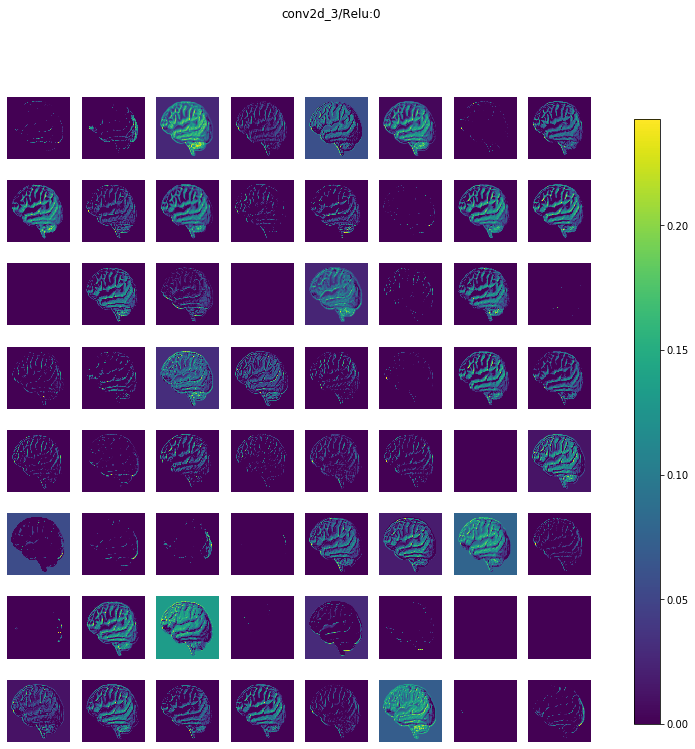

max_pooling2d_3/MaxPool:0 (1, 62, 62, 64) 


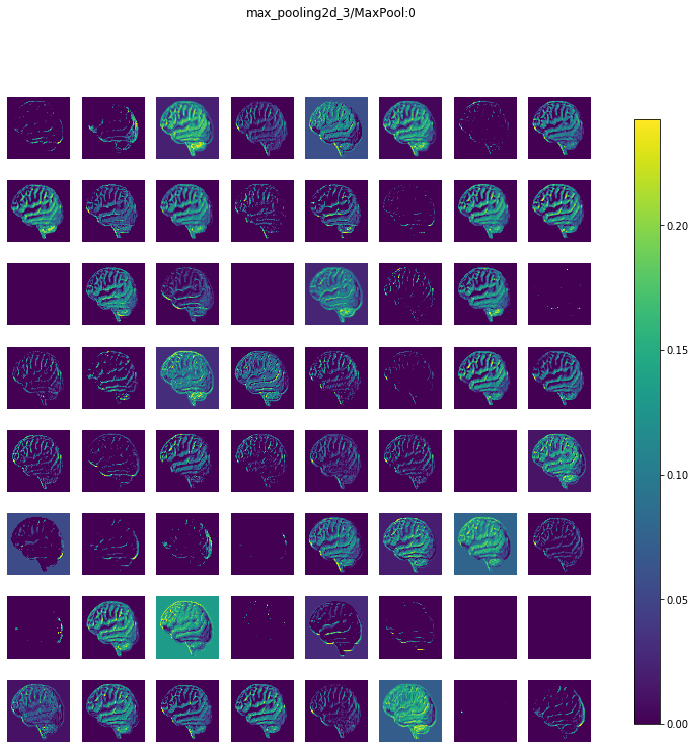

conv2d_4/Relu:0 (1, 60, 60, 64) 


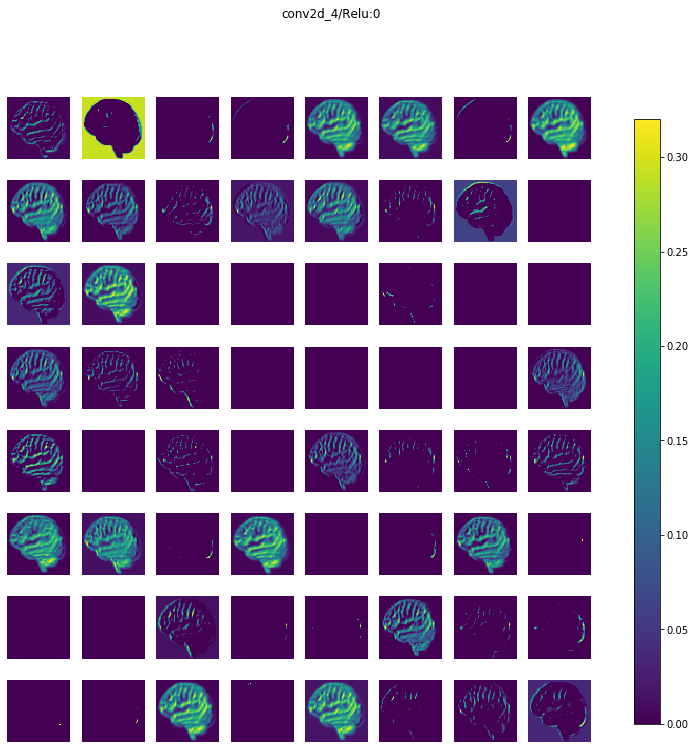

max_pooling2d_4/MaxPool:0 (1, 30, 30, 64) 


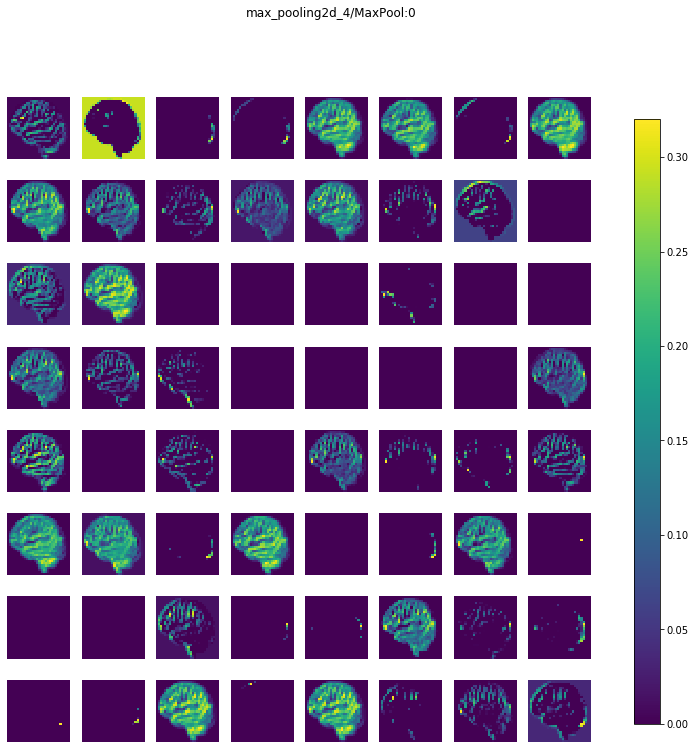

conv2d_5/Relu:0 (1, 28, 28, 64) 


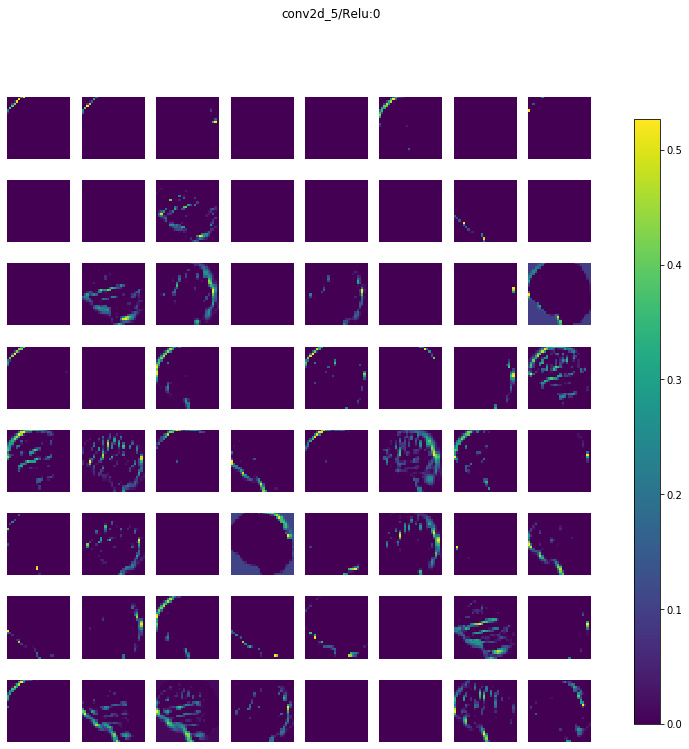

max_pooling2d_5/MaxPool:0 (1, 14, 14, 64) 


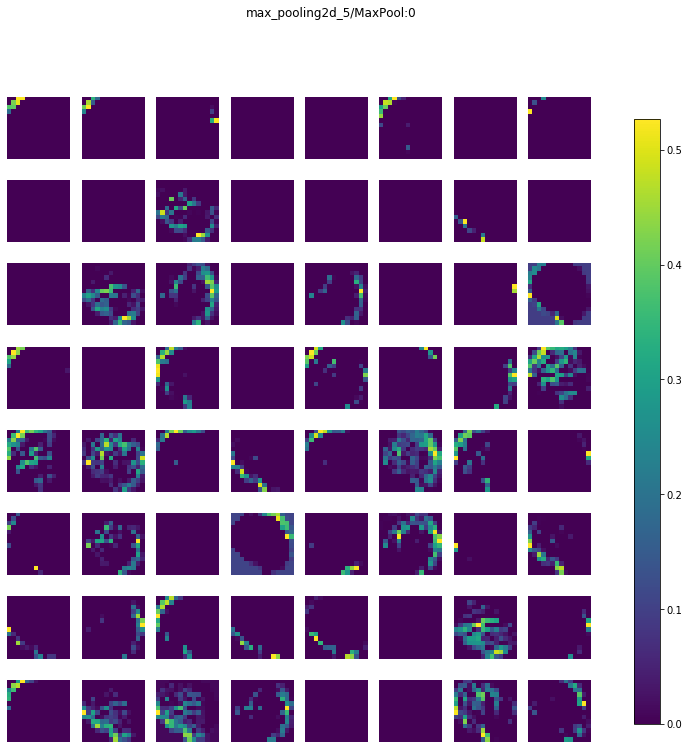

flatten_1/Reshape:0 (1, 12544) -> Skipped. 2D Activations.
dense_1/Relu:0 (1, 512) -> Skipped. 2D Activations.
dense_2/Softmax:0 (1, 5) -> Skipped. 2D Activations.


In [16]:
from keract import display_activations
display_activations(activations, save=False)

### Can also display heatmaps

conv2d_1/Relu:0 (1, 510, 510, 16) 


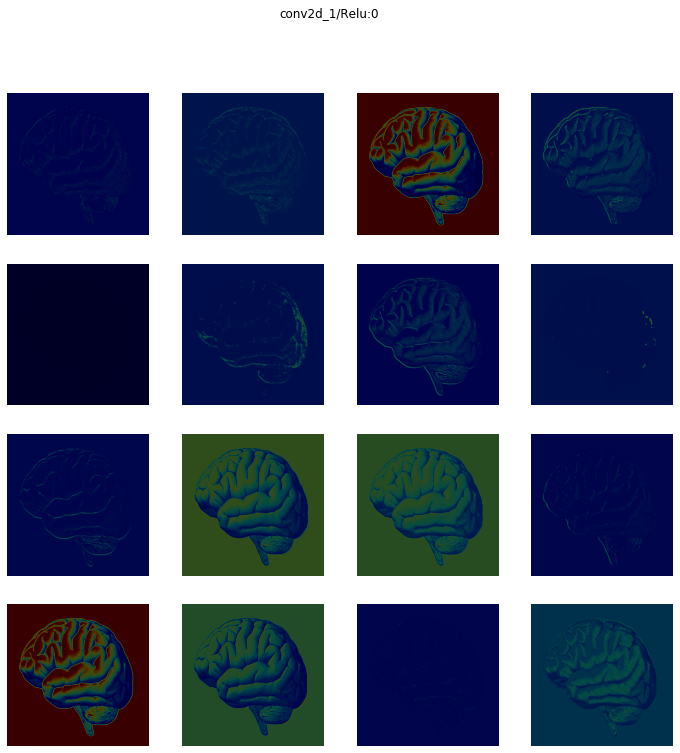

max_pooling2d_1/MaxPool:0 (1, 255, 255, 16) 


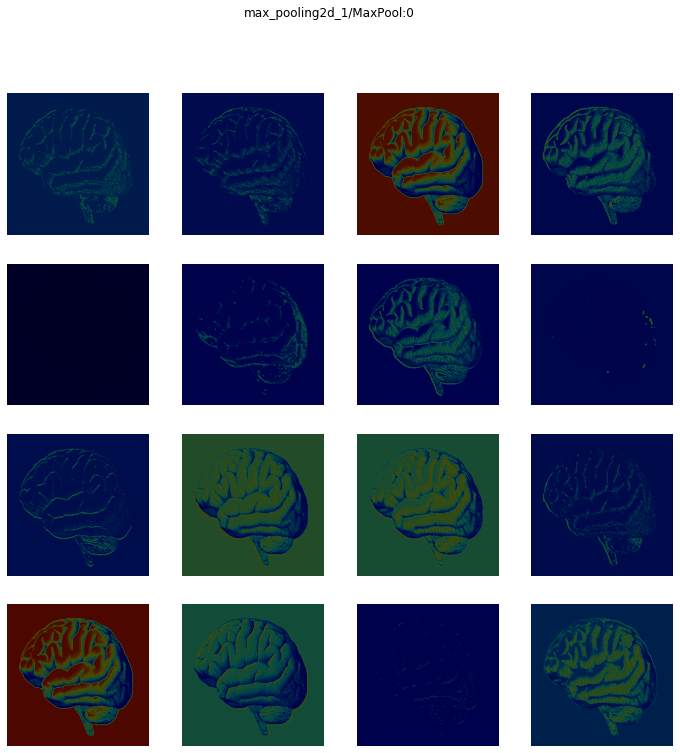

conv2d_2/Relu:0 (1, 253, 253, 32) 


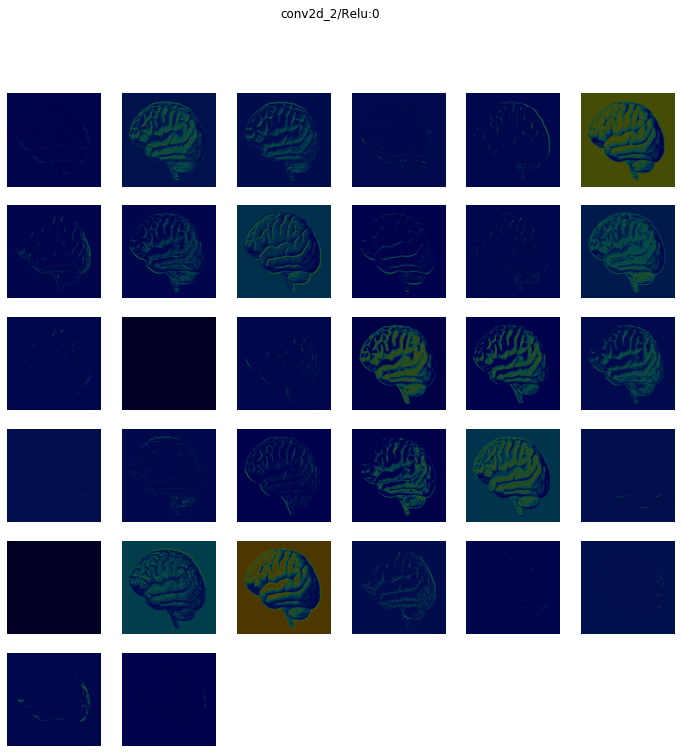

max_pooling2d_2/MaxPool:0 (1, 126, 126, 32) 


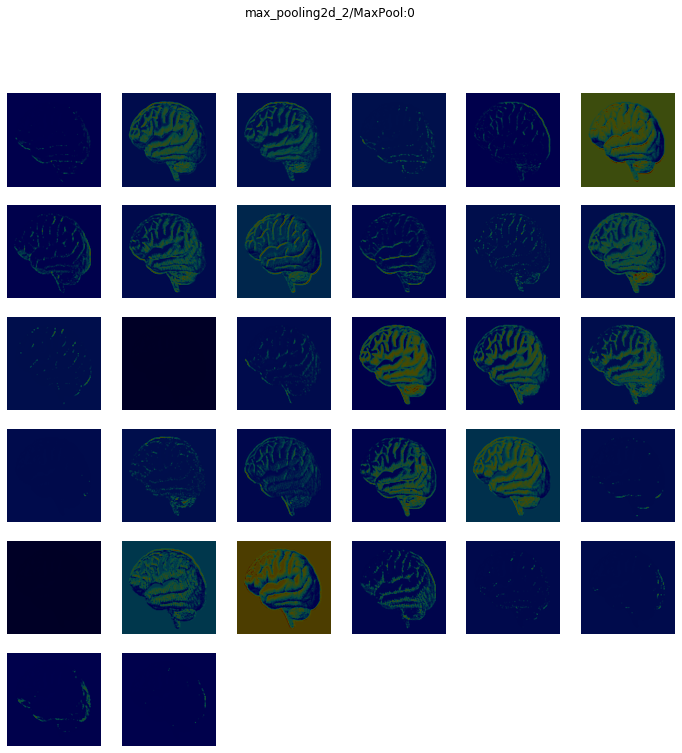

conv2d_3/Relu:0 (1, 124, 124, 64) 


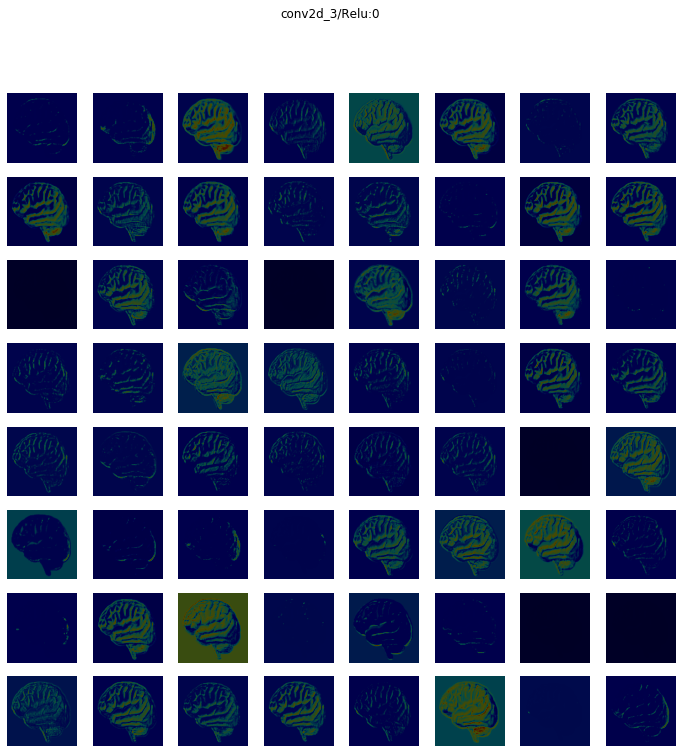

max_pooling2d_3/MaxPool:0 (1, 62, 62, 64) 


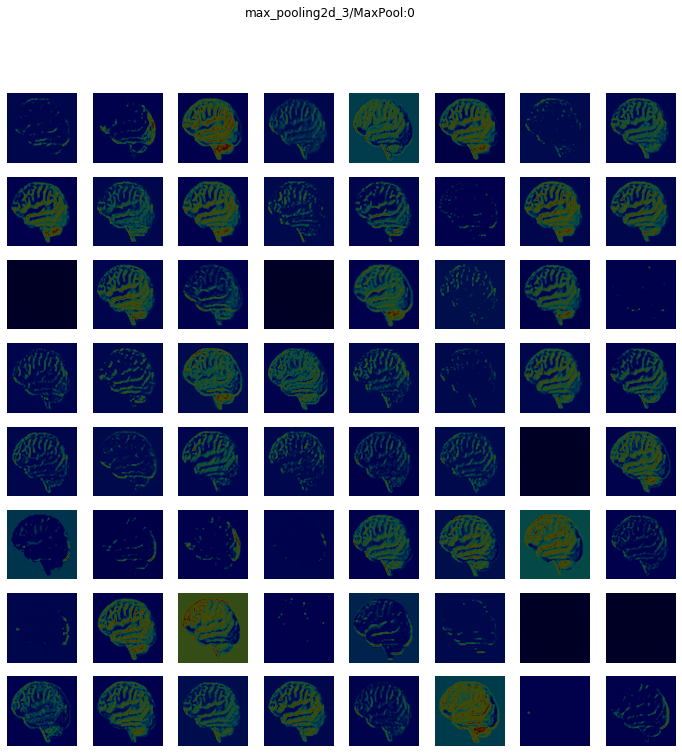

conv2d_4/Relu:0 (1, 60, 60, 64) 


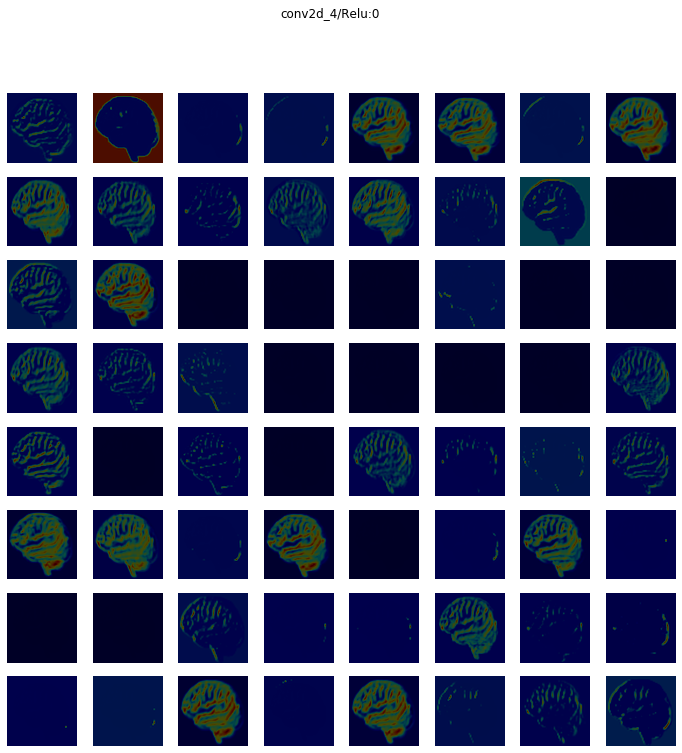

max_pooling2d_4/MaxPool:0 (1, 30, 30, 64) 


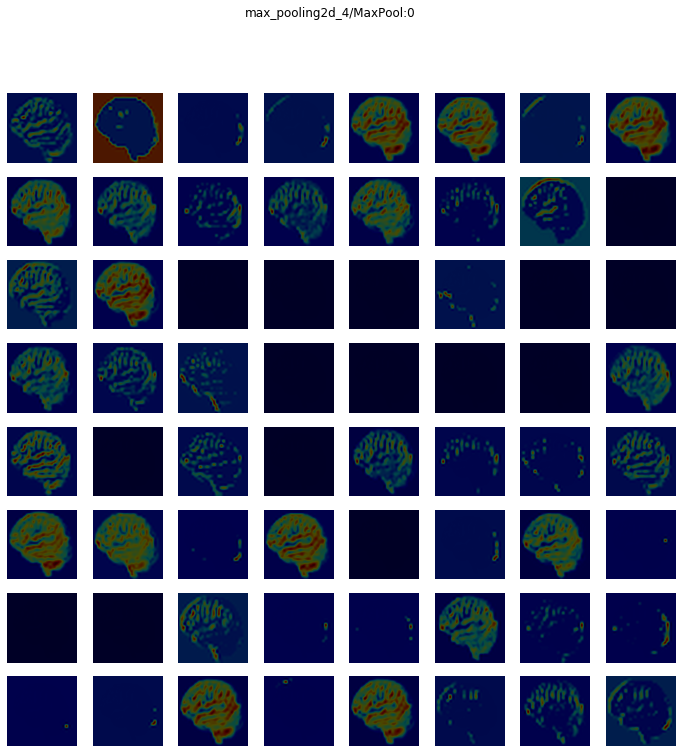

conv2d_5/Relu:0 (1, 28, 28, 64) 


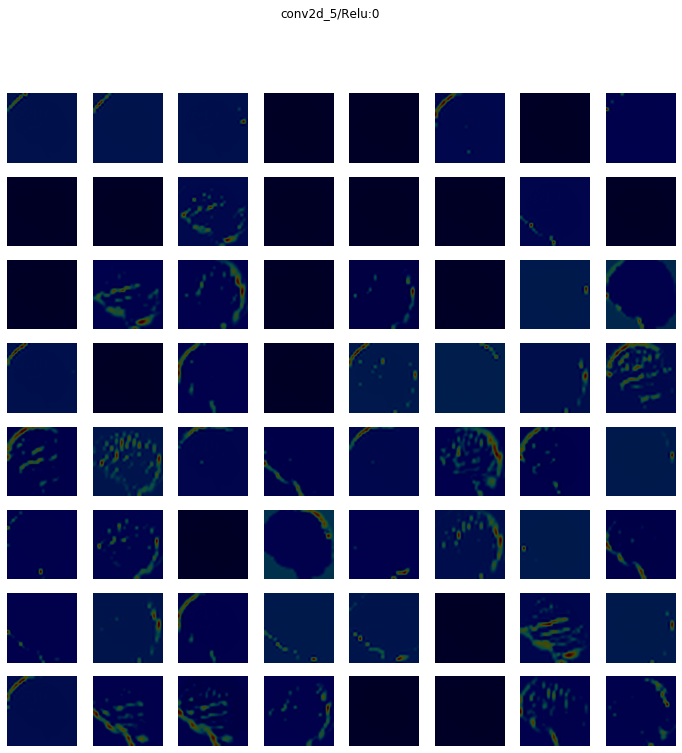

max_pooling2d_5/MaxPool:0 (1, 14, 14, 64) 


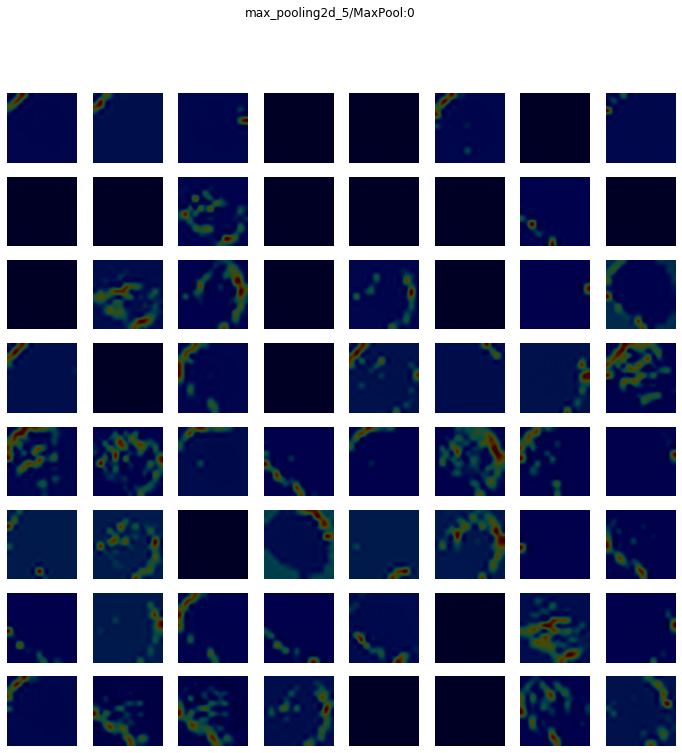

flatten_1/Reshape:0 (1, 12544) -> Skipped. 2D Activations.
dense_1/Relu:0 (1, 512) -> Skipped. 2D Activations.
dense_2/Softmax:0 (1, 5) -> Skipped. 2D Activations.


In [17]:
from keract import display_heatmaps
display_heatmaps(activations, x, save=False)